In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

words = open('names.txt').read().splitlines()
words = list(set(words)) # deduplicate
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
context_len = max(len(w) for w in words) + 20

# train set
random.seed(42)
random.shuffle(words)
xs, ys, masks = [], [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    tks = [stoi[ch] for ch in chs]
    mask = [1] * len(tks) + [0] * (context_len - len(tks))
    tks = tks + [0] * (context_len - len(tks))
    xs.append(tks[:-1])
    ys.append(tks[1:])
    masks.append(mask[:-1]) # mask for special token '.'

xs = torch.tensor(xs)
ys = torch.tensor(ys)
masks = torch.tensor(masks)

from dataclasses import dataclass

@dataclass
class Config:
    n_embd = 27

class Net(nn.Module):
    def __init__(self, config=Config()):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(27, config.n_embd)
        self.wpe = nn.Embedding(context_len, config.n_embd)
        self.qkv = nn.Linear(config.n_embd, config.n_embd*3)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd*4),
            nn.GELU(),
            nn.Linear(config.n_embd*4, config.n_embd),
        )
        self.lm = nn.Linear(config.n_embd, 27)
        self.wte.weight = self.lm.weight
        self.register_buffer('tril', torch.tril(torch.ones(context_len, context_len)))

    def forward(self, x):
        x = self.wte(x) + self.wpe(torch.arange(x.shape[1], device=x.device))
        # attn
        q, k, v = self.qkv(x).split(self.config.n_embd, dim=2)
        w = (q @ k.transpose(1, 2)) / (self.config.n_embd ** 0.5)
        w = w.masked_fill(self.tril[:w.shape[2], :w.shape[2]] == 0, float('-inf'))
        attn = w.softmax(dim=-1) @ v
        x = x + attn
        # mlp
        x = x + self.mlp(x)
        x = self.lm(x)
        return x


In [2]:
def cal_loss(xb, yb, mask):
    xb = xb.to(device)
    yb = yb.to(device)
    mask = mask.to(device)
    logits = net(xb)
    log_probs = F.log_softmax(logits, dim=-1)
    nlls = -log_probs.gather(dim=-1, index=yb.unsqueeze(-1)).squeeze(-1)
    loss = (nlls * mask).sum() / mask.nonzero().shape[0] # only consider the loss of the non-zero mask
    return loss

device = 'cuda'
ini_lr = 0.01
num_epochs = 600

torch.manual_seed(42)
net = Net().to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=ini_lr)
data = list(zip(xs, ys, masks))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))

for epoch in range(num_epochs):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True) # re-shuffle
    for step, (xb, yb, mask) in enumerate(train_dataloader):
        loss = cal_loss(xb, yb, mask)
        if step % 1 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb, mask in val_dataloader:
                    val_loss += cal_loss(xb, yb, mask)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr = ini_lr * (1 - (epoch / num_epochs) * 0.9)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        norm = sum(p.grad.norm()**2 for p in net.parameters()).sqrt()
        max_v = max(p.abs().max() for p in net.parameters())
        print(f'norm: {norm:.4f} max_v: {max_v:.4f}')


epoch 0 step 0 train loss: 3.3645 val loss: 3.3703
norm: 1.0778 max_v: 3.1971
epoch 1 step 0 train loss: 2.9953 val loss: 3.0009
norm: 0.9003 max_v: 3.2065
epoch 2 step 0 train loss: 2.7266 val loss: 2.7309
norm: 0.6898 max_v: 3.2158
epoch 3 step 0 train loss: 2.6402 val loss: 2.6417
norm: 1.2038 max_v: 3.2253
epoch 4 step 0 train loss: 2.5081 val loss: 2.5131
norm: 0.7469 max_v: 3.2349
epoch 5 step 0 train loss: 2.4345 val loss: 2.4443
norm: 0.5535 max_v: 3.2445
epoch 6 step 0 train loss: 2.4196 val loss: 2.4326
norm: 0.7198 max_v: 3.2542
epoch 7 step 0 train loss: 2.3935 val loss: 2.4071
norm: 0.5171 max_v: 3.2640
epoch 8 step 0 train loss: 2.3751 val loss: 2.3877
norm: 0.3572 max_v: 3.2737
epoch 9 step 0 train loss: 2.3684 val loss: 2.3794
norm: 0.5337 max_v: 3.2827
epoch 10 step 0 train loss: 2.3460 val loss: 2.3567
norm: 0.4698 max_v: 3.2909
epoch 11 step 0 train loss: 2.3237 val loss: 2.3347
norm: 0.2067 max_v: 3.2982
epoch 12 step 0 train loss: 2.3252 val loss: 2.3354
norm: 0.42

In [4]:
g = torch.Generator(device).manual_seed(42)
for _ in range(10):
    idx = torch.zeros((1,1), dtype=torch.int32, device=device)
    for _ in range(context_len):
        prob = net(idx).softmax(dim=-1)[:,-1,:]
        idx_next = torch.multinomial(prob, 1, generator=g)
        idx = torch.cat([idx, idx_next], dim=-1)
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx[0]))


.kritarik.
.vilan.
.endadar.
.everien.
.rishian.
.fikelligh.
.brion.
.amurgem.
.miwison.
.diony.


(-0.5, 26.5, 26.5, -0.5)

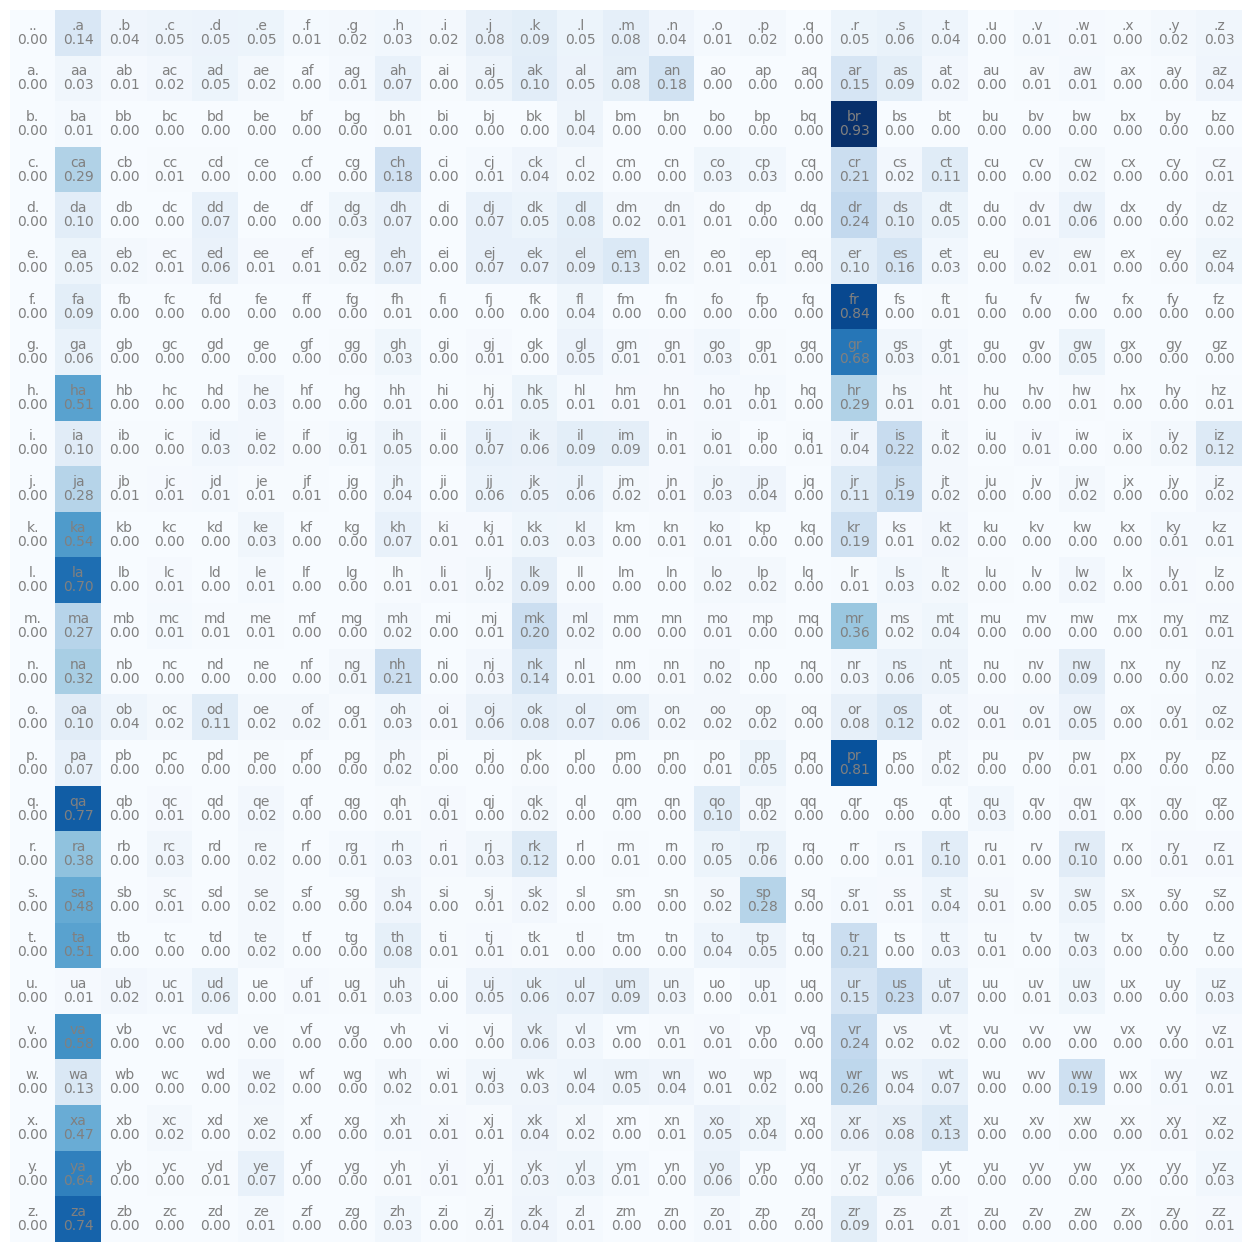

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# consider context length = 2, start with '.abcde...xyz', predict the next character
netP = net(torch.arange(27).to(device).unsqueeze(1)).softmax(dim=-1).detach().squeeze(1).cpu().numpy()
plt.figure(figsize=(16,16))
plt.imshow(netP, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{netP[i,j]:.2f}', ha="center", va="top", color="gray")

plt.axis('off')